In [1]:
import sys
sys.path.insert(0, './src')

import random

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from data import *
from models import *
from train import *
from scores import *
from run import setup_seed

In [2]:
DATA_PATH = "./data/PSI_Biology_solubility_trainset.csv"

In [3]:
config = {
    "max_chain_length": 810,  # Sequence trim length
    "num_epochs": 1000,  # Number of iterations
    "eval_step": 10,  # Evaluate model each ... iters
    "batch_size": 32,
    "weight_decay": 1e-2,
    "learning_rate": 1e-3,
}

model_conf = {
    "cnn": [
        # in_channels, out_channels, kernel_size, dropout_p
        [20, 4, 3, 0.25],
        [4, 2, 3, 0.25],
        [2, 1, 3, 0.25],
    ],
    "linear": [
        # in_features, #out_features, dropout_p
        [config["max_chain_length"], config["max_chain_length"] // 2, 0.25],
    ],
}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
y, x = load_data(DATA_PATH, device, config["max_chain_length"])
x = encode_one_hot(x)

In [6]:
criterion = nn.BCEWithLogitsLoss(pos_weight=(y == 0).sum() / y.sum()).to(device)

In [7]:
EPOCHS = 100

def train(seed):
    setup_seed(seed)
    
    data = {}
    data["x_train"], data["x_test"], data["y_train"], data["y_test"] = train_test_split(
        x, y, test_size=0.2
    )

    # Initialisation
    model = Model1(model_conf)
    model.to(device)
    
    optimiser = torch.optim.AdamW(
        model.parameters(),
        lr=config["learning_rate"],
        weight_decay=config["weight_decay"],
    )

    train_losses = []
    test_losses = []
    accs = []
    precs = []
    recalls = []
    f1s = []
    rocs = []

    # Training
    for e in range(1, EPOCHS + 1):
        train_epoch(data, model, optimiser, criterion, config["batch_size"])

        # Evaluation
        model.eval()
        with torch.no_grad():
            # Train loss
            output = model(data["x_train"]).squeeze()
            train_loss = criterion(output, data["y_train"].float())
            train_losses.append(train_loss.cpu())

            # Test loss
            y_pred = model(data["x_test"]).squeeze()
            test_loss = criterion(y_pred, data["y_test"].float())
            test_losses.append(test_loss.cpu())

            s = scores(y_pred, data["y_test"])
            accs.append(s['accuracy'].cpu())
            precs.append(s['precision'].cpu())
            recalls.append(s['recall'].cpu())
            f1s.append(s['f1'].cpu())
            rocs.append(s['roc_auc'])

        model.train()
    
    return train_losses, test_losses, accs, precs, recalls, f1s, rocs

In [12]:
torch.cuda.empty_cache()

ITERATIONS = 5

train_losses_ = np.zeros(EPOCHS)
test_losses_ = np.zeros(EPOCHS)
accs_ = np.zeros(EPOCHS)
precs_ = np.zeros(EPOCHS)
recalls_ = np.zeros(EPOCHS)
f1s_ = np.zeros(EPOCHS)
rocs_ = np.zeros(EPOCHS)

for seed in range(1, ITERATIONS + 1):
    train_losses, test_losses, accs, precs, recalls, f1s, rocs = train(seed)
    train_losses_ += train_losses
    test_losses_ += test_losses
    accs_ += accs
    precs_ += precs
    recalls_ += recalls
    f1s_ += f1s
    rocs_ += rocs

train_losses_ /= ITERATIONS
test_losses_ /= ITERATIONS
accs_ /= ITERATIONS
precs_ /= ITERATIONS
recalls_ /= ITERATIONS
f1s_ /= ITERATIONS
rocs_ /= ITERATIONS

In [17]:
# index of best roc auc
i = np.argmax(f1s_)
print(
        "\n".join(
            [
                f"Epoch: {i}",
                f"Accuracy: {accs_[i]:.3f}",
                f"Precision: {precs_[i]:.3f}",
                f"Recall: {recalls_[i]:.3f}",
                f"F1: {f1s_[i]:.3f}",
                f"ROC AUC: {rocs_[i]:.3f}",
            ]
        )
    )

Epoch: 63
Accuracy: 0.660
Precision: 0.766
Recall: 0.738
F1: 0.747
ROC AUC: 0.661


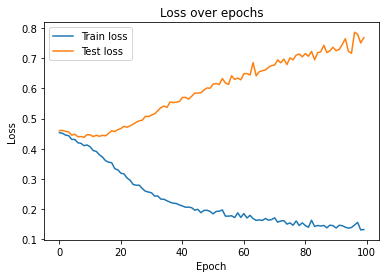

In [14]:
# Loss plot

fig, ax = plt.subplots()
ax.plot(train_losses_)
ax.plot(test_losses_)

ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss over epochs')
ax.legend(['Train loss', 'Test loss'])

fig.savefig("model1_1.png")
plt.show()

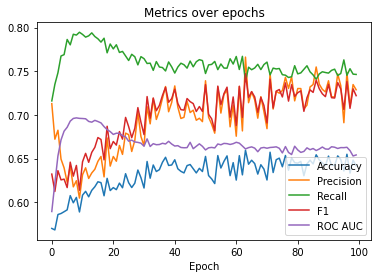

In [15]:
# Metrics plot

fig, ax = plt.subplots()
ax.plot(accs_)
ax.plot(precs_)
ax.plot(recalls_)
ax.plot(f1s_)
ax.plot(rocs_)

ax.set(xlabel='Epoch',
       title='Metrics over epochs')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'])

fig.savefig("model1_2.png")
plt.show()